# Tema 1 Învățare Automată
# Glodea Eusebiu - 342C2
## Setul de date Fashion

*Nota: In documentul de fata a fost implementata tema pentru setul de date fashion. In arhiva temei se va afla si fisierul .ipynb cu implementarea temei pentru setul de date fruits.*

## Pregatirea mediului de lucru

In [1]:
from __future__ import annotations
from typing import Optional, Dict, Callable
from pathlib import Path
from copy import deepcopy
from collections import Counter

import pandas as pd
import numpy as np
from graphviz import Digraph, Source
from IPython.display import display as idisplay
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

from scipy.stats import chi2_contingency
from scipy import stats

!pip install python-mnist
import mnist
import urllib.request
import os
import zipfile
import tensorflow as tf

import cv2
import glob
import string
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC

# Functie utilizata pentru a incarca datele de train si test din setul de date fashion
import os
os.makedirs('utils', exist_ok=True)

with open('utils/mnist_reader.py', 'w') as f:
    f.write('''
import os
import gzip
import numpy as np

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')

    # Load labels
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    # Load images
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28 * 28)

    return images, labels
    ''')

print("mnist_reader.py has been created successfully!")

os.makedirs('fashion', exist_ok=True)


mnist_reader.py has been created successfully!


*Pentru continuarea rularii sunt necesare adaugarea fisierelor din arhiva trimisa, aflate in folderul fashion, care trebuie adaugate manual in folderul /content/fashion creat in celula de cod anterioara*

## Pregatirea setului de date Fashion

In [2]:
import sys
sys.path.append('utils')
import mnist_reader


X_fashion_train, y_fashion_train = mnist_reader.load_mnist('/content/fashion', kind='train')
X_fashion_test, y_fashion_test = mnist_reader.load_mnist('/content/fashion', kind='t10k')

print("Fashion Training data shape:", X_fashion_train.shape, y_fashion_train.shape)
print("Fashion Test data shape:", X_fashion_test.shape, y_fashion_test.shape)


Fashion Training data shape: (60000, 784) (60000,)
Fashion Test data shape: (10000, 784) (10000,)


# Extragerea de atribute

In [3]:
import cv2
from sklearn.decomposition import PCA
from skimage.feature import hog
from skimage.transform import resize
from joblib import Parallel, delayed
from scipy.ndimage import zoom

## Metoda HOG (Histogram of Oriented Gradients)

In [12]:
def compute_hog(image, hog_params):
    return hog(image, **hog_params)

hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
}

def HOG(dataset, hog_params):
  dataset_images = dataset.reshape(-1, 28, 28)
  dataset_hog = Parallel(n_jobs=-1)(delayed(compute_hog)(img, hog_params)
                for img in dataset_images)
  dataset_hog = np.array(dataset_hog)
  return dataset_hog

In [5]:
# dureaza ~30 sec
X_fashion_train_hog = HOG(X_fashion_train, hog_params)
X_fashion_test_hog = HOG(X_fashion_test, hog_params)

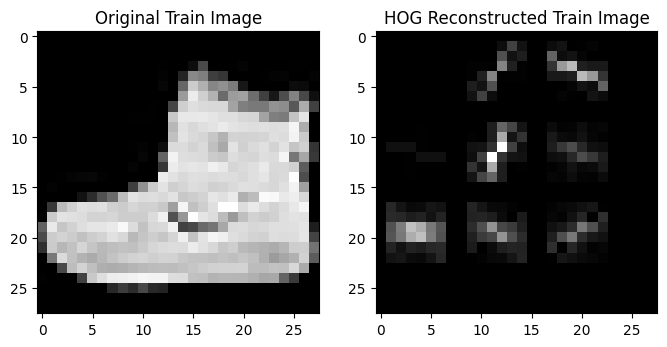

In [13]:
original_image = tf.squeeze(X_fashion_train[0]).numpy()
original_image = original_image.reshape(28, 28)

hog_image = hog(original_image,
                orientations=hog_params['orientations'],
                pixels_per_cell=hog_params['pixels_per_cell'],
                cells_per_block=hog_params['cells_per_block'],
                block_norm=hog_params['block_norm'],
                visualize=True)

# hog_image e tuplu format din (hog_features, hog_image)
hog_image = hog_image[1]
hog_feautrues = hog_image[0]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Train Image')

axes[1].imshow(hog_image, cmap='gray')
axes[1].set_title('HOG Reconstructed Train Image')

plt.show()

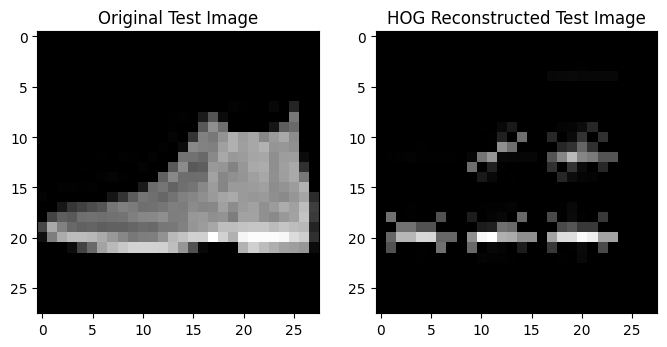

In [8]:
original_image = tf.squeeze(X_fashion_test[0]).numpy()
original_image = original_image.reshape(28, 28)

hog_image = hog(original_image,
                orientations=hog_params['orientations'],
                pixels_per_cell=hog_params['pixels_per_cell'],
                cells_per_block=hog_params['cells_per_block'],
                block_norm=hog_params['block_norm'],
                visualize=True)

hog_image = hog_image[1]
hog_feautrues = hog_image[0]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Test Image')

axes[1].imshow(hog_image, cmap='gray')
axes[1].set_title('HOG Reconstructed Test Image')

plt.show()

## Metoda PCA (Principal Component Analysis)

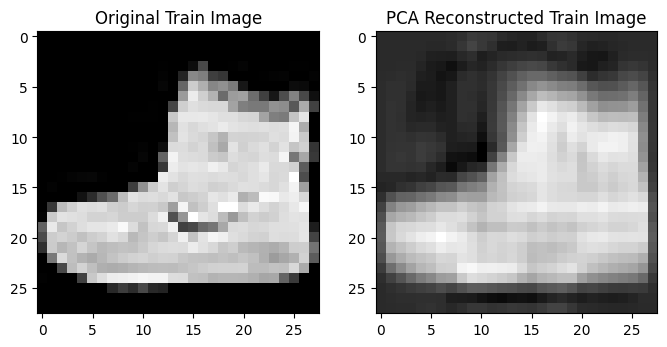

In [ ]:
def reconstruct_image_tf(images_pca, components, mean, n_components):
    reconstructed_flat = tf.matmul(images_pca, tf.transpose(components[:, :n_components])) + mean
    return reconstructed_flat

n_components = 50
images_flattened = tf.cast(tf.reshape(X_fashion_train, (X_fashion_train.shape[0], -1)), dtype=tf.float32)

mean = tf.reduce_mean(images_flattened, axis=0)
images_centered = images_flattened - mean
s, u, v = tf.linalg.svd(images_centered)

X_fashion_train_pca = tf.matmul(images_centered, v[:, :n_components])

original_image = tf.squeeze(X_fashion_train[0]).numpy()
original_image = original_image.reshape(28, 28)
reconstructed_image_flat = reconstruct_image_tf(
    X_fashion_train_pca[0:1], v, mean, n_components
)
reconstructed_image = tf.reshape(reconstructed_image_flat, original_image.shape).numpy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Train Image')

axes[1].imshow(reconstructed_image, cmap='gray')
axes[1].set_title('PCA Reconstructed Train Image')

plt.show()

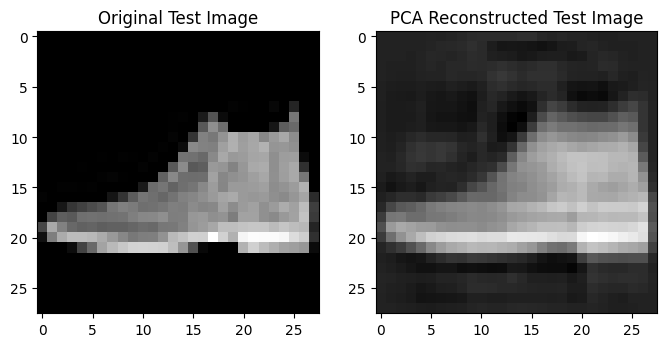

In [ ]:
n_components = 50
images_flattened = tf.cast(tf.reshape(X_fashion_test, (X_fashion_test.shape[0], -1)), dtype=tf.float32)

mean = tf.reduce_mean(images_flattened, axis=0)
images_centered = images_flattened - mean
s, u, v = tf.linalg.svd(images_centered)

X_fashion_test_pca = tf.matmul(images_centered, v[:, :n_components])

original_image = tf.squeeze(X_fashion_test[0]).numpy()
original_image = original_image.reshape(28, 28)
reconstructed_image_flat = reconstruct_image_tf(
    X_fashion_test_pca[0:1], v, mean, n_components
)
reconstructed_image = tf.reshape(reconstructed_image_flat, original_image.shape).numpy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Test Image')

axes[1].imshow(reconstructed_image, cmap='gray')
axes[1].set_title('PCA Reconstructed Test Image')

plt.show()

# Vizualizarea Atributelor Extrase

## Analiza echilibrului de clase

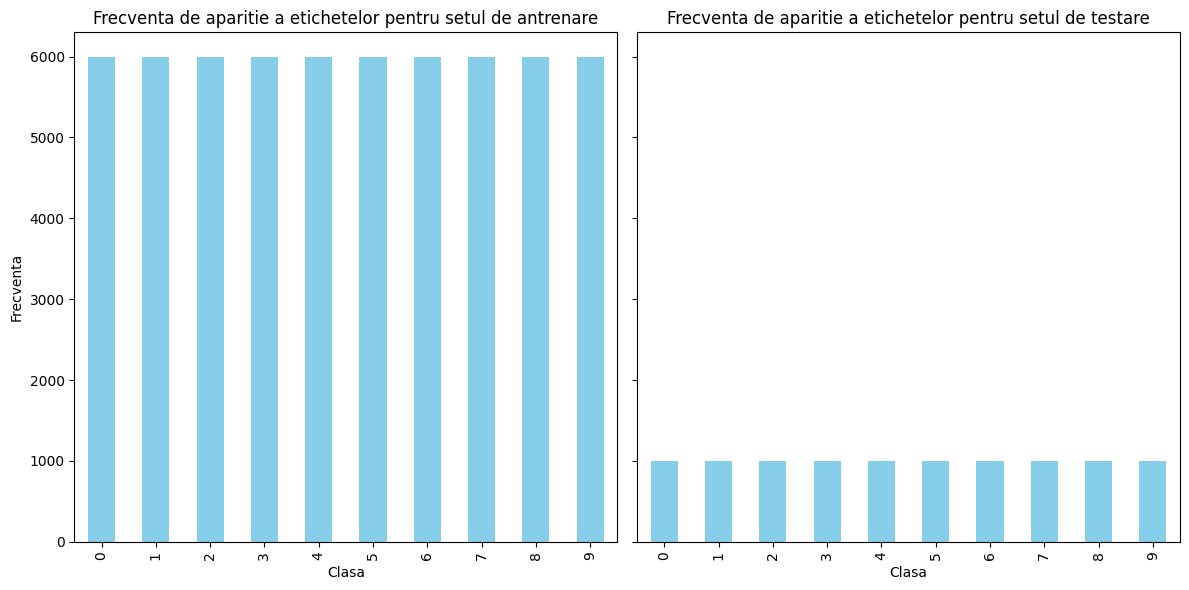

In [ ]:
train_df = pd.DataFrame({'Label': y_fashion_train})
test_df = pd.DataFrame({'Label': y_fashion_test})

train_counts = train_df['Label'].value_counts().sort_index()
test_counts = test_df['Label'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

train_counts.plot.bar(ax=axes[0], color='skyblue')
axes[0].set_title('Frecventa de aparitie a etichetelor pentru setul de antrenare')
axes[0].set_xlabel('Clasa')
axes[0].set_ylabel('Frecventa')

test_counts.plot.bar(ax=axes[1], color='skyblue')
axes[1].set_title('Frecventa de aparitie a etichetelor pentru setul de testare')
axes[1].set_xlabel('Clasa')
axes[1].set_ylabel('Frecventa')

plt.tight_layout()
plt.show()

# sunt cate 6000 de haine pt fiec clasa (0-9) la train, respectiv cate 1000 la test

## Vizualizarea cantitativă / calitativă a efectului de extragere a atributelor

### Vizualizari cantitative

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from skimage import color

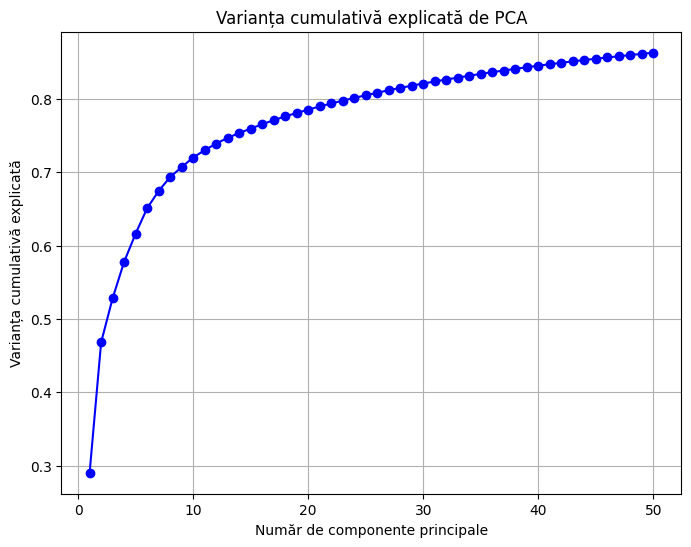

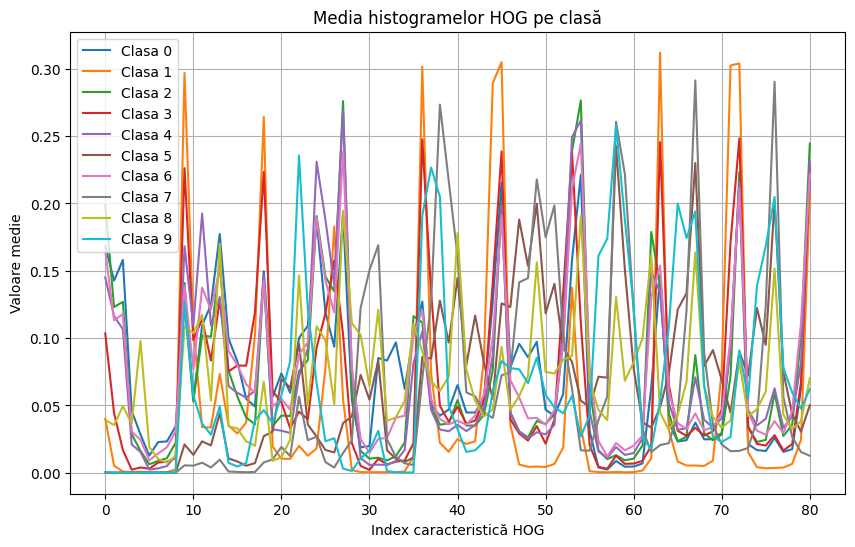

In [10]:
# Pe HOG nu pot face varianta cumulativa, iar pe PCA nu pot face media histogramelor per clasa
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_fashion_train)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='b')
plt.title('Varianța cumulativă explicată de PCA')
plt.xlabel('Număr de componente principale')
plt.ylabel('Varianța cumulativă explicată')
plt.grid()
plt.show()

def extract_hog_features(X, pixels_per_cell=(8, 8)):
    hog_features = []
    for sample in X:
        image = sample.reshape(28, 28)
        features = hog(image, pixels_per_cell=pixels_per_cell, block_norm='L2-Hys')
        hog_features.append(features)
    return np.array(hog_features)

hog_features_train = extract_hog_features(X_fashion_train)

mean_hog_per_class = []
for cls in np.unique(y_fashion_train):
    mean_hog_per_class.append(hog_features_train[y_fashion_train == cls].mean(axis=0))

plt.figure(figsize=(10, 6))
for cls, hog_mean in enumerate(mean_hog_per_class):
    plt.plot(hog_mean, label=f'Clasa {cls}')
plt.title('Media histogramelor HOG pe clasă')
plt.xlabel('Index caracteristică HOG')
plt.ylabel('Valoare medie')
plt.legend()
plt.grid()
plt.show()

### Vizualizari calitative

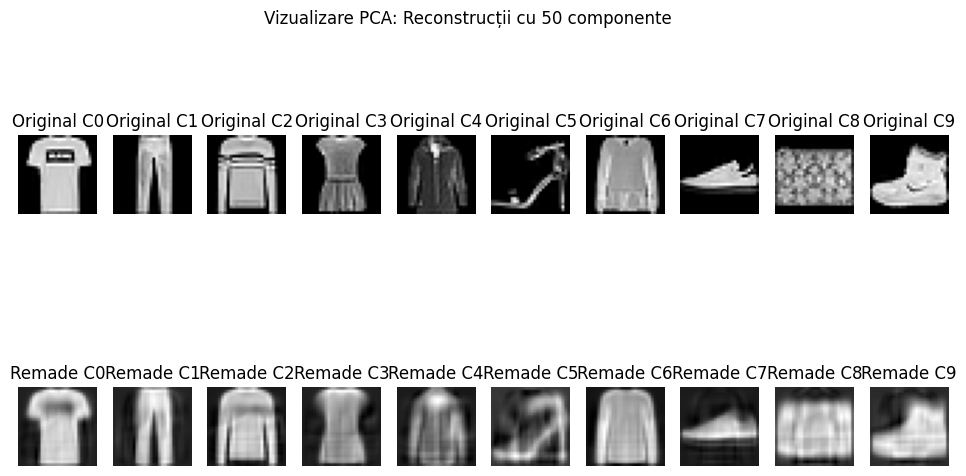

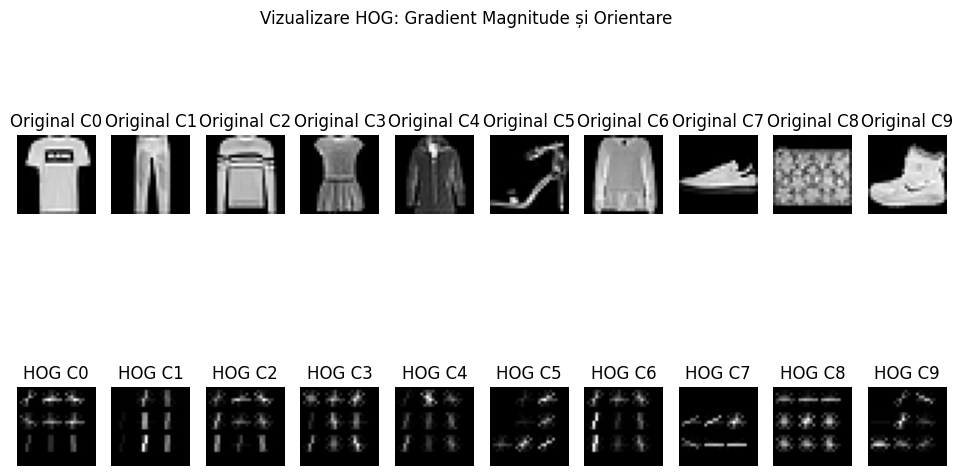

In [14]:



def visualize_pca_reconstruction(X_images, y_labels, classes, n_components=50):
    fig, axes = plt.subplots(2, len(classes), figsize=(12, 6))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    pca = PCA(n_components=50)
    pca.fit(X_images.reshape(X_images.shape[0], -1))

    for i, cls in enumerate(classes):
        idx = np.where(y_labels == cls)[0][0]
        original_image = X_images[idx]

        image_flat = original_image.flatten()
        reduced = pca.transform(image_flat.reshape(1, -1))
        reconstructed = pca.inverse_transform(reduced).reshape(original_image.shape)

        axes[0, i].imshow(original_image.reshape(28, 28), cmap='gray')
        axes[0, i].set_title(f'Original C{cls}')
        axes[0, i].axis('off')

        axes[1, i].imshow(reconstructed.reshape(28, 28), cmap='gray')
        axes[1, i].set_title(f'Remade C{cls}')
        axes[1, i].axis('off')

    plt.suptitle(f'Vizualizare PCA: Reconstrucții cu {n_components} componente')
    plt.show()

def visualize_hog(X_images, y_labels, classes):
    fig, axes = plt.subplots(2, len(classes), figsize=(12, 6))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    for i, cls in enumerate(classes):
        idx = np.where(y_labels == cls)[0][0]
        original_image = X_images[idx]

        features, hog_image = hog(
            original_image.reshape(28, 28),
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            visualize=True
        )

        axes[0, i].imshow(original_image.reshape(28, 28), cmap='gray')
        axes[0, i].set_title(f'Original C{cls}')
        axes[0, i].axis('off')

        axes[1, i].imshow(hog_image, cmap='gray')
        axes[1, i].set_title(f'HOG C{cls}')
        axes[1, i].axis('off')

    plt.suptitle('Vizualizare HOG: Gradient Magnitude și Orientare')
    plt.show()

classes = np.unique(y_fashion_train)
visualize_pca_reconstruction(X_fashion_train, y_fashion_train, classes, n_components=50)
visualize_hog(X_fashion_train, y_fashion_train, classes)

# Standardizarea și selecția atributelor

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif

In [ ]:
# X_fashion_train_hog, X_fashion_test_hog, X_fashion_train_pca, X_fashion_test_pca
# y_fashion_train, y_fashion_test

scaler = StandardScaler()
X_standardized_train_hog = scaler.fit_transform(X_fashion_train_hog)
X_standardized_test_hog = scaler.fit_transform(X_fashion_test_hog)
X_standardized_train_pca = scaler.fit_transform(X_fashion_train_pca)
X_standardized_test_pca = scaler.fit_transform(X_fashion_test_pca)

select_percentile = SelectPercentile(score_func=f_classif, percentile=20)  # Selectează 20% cele mai bune caracteristici
X_perc_train_hog = select_percentile.fit_transform(X_standardized_train_hog, y_fashion_train)
X_perc_test_hog = select_percentile.transform(X_standardized_test_hog)
X_perc_train_pca = select_percentile.fit_transform(X_standardized_train_pca, y_fashion_train)
X_perc_test_pca = select_percentile.transform(X_standardized_test_pca)

print(X_perc_train_hog.shape)
print(X_fashion_train_hog.shape)
print(X_fashion_train.shape)



(60000, 29)
(60000, 144)
(60000, 784)


In [ ]:
X_train_combined_features = np.hstack([X_perc_train_hog, X_perc_train_pca])
X_test_combined_features = np.hstack([X_perc_test_hog, X_perc_test_pca])

print(X_fashion_train.shape)
print(X_train_combined_features.shape)

(60000, 784)
(60000, 39)


# Utilizarea algoritmilor de Învățare Automată

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

X_train, X_test, y_train, y_test = X_train_combined_features, X_test_combined_features, y_fashion_train, y_fashion_test

In [ ]:
def run_model(model, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='viridis')
    plt.title(f'Confusion Matrix ({model.__class__.__name__})')
    plt.show()

    return best_model, report, accuracy



## Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters: {'C': 10, 'multi_class': 'multinomial'}


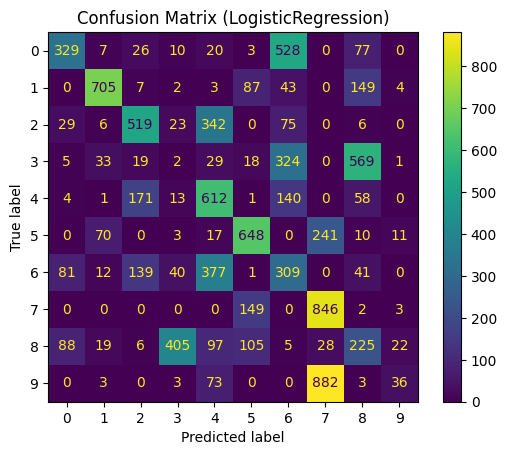

              precision    recall  f1-score   support

           0       0.61      0.33      0.43      1000
           1       0.82      0.70      0.76      1000
           2       0.59      0.52      0.55      1000
           3       0.00      0.00      0.00      1000
           4       0.39      0.61      0.48      1000
           5       0.64      0.65      0.64      1000
           6       0.22      0.31      0.25      1000
           7       0.42      0.85      0.56      1000
           8       0.20      0.23      0.21      1000
           9       0.47      0.04      0.07      1000

    accuracy                           0.42     10000
   macro avg       0.44      0.42      0.40     10000
weighted avg       0.44      0.42      0.40     10000



In [ ]:
# dureaza ~ 2min 40s
lr_model = LogisticRegression(max_iter=5000)
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'multi_class': ['ovr', 'multinomial']
}
lr_params, lr_metrics, lr_accuracy = run_model(lr_model, lr_param_grid, X_train, y_train, X_test, y_test)
print(lr_metrics)


## SVM

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'C': 10, 'kernel': 'rbf'}


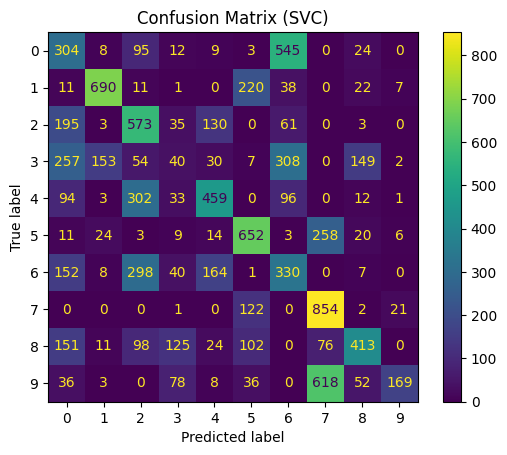

              precision    recall  f1-score   support

           0       0.25      0.30      0.27      1000
           1       0.76      0.69      0.73      1000
           2       0.40      0.57      0.47      1000
           3       0.11      0.04      0.06      1000
           4       0.55      0.46      0.50      1000
           5       0.57      0.65      0.61      1000
           6       0.24      0.33      0.28      1000
           7       0.47      0.85      0.61      1000
           8       0.59      0.41      0.48      1000
           9       0.82      0.17      0.28      1000

    accuracy                           0.45     10000
   macro avg       0.48      0.45      0.43     10000
weighted avg       0.48      0.45      0.43     10000



In [ ]:
# dureaza ~28min
svm_model = SVC()
svm_param_grid = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf']
}
svm_params, svm_metrics, svm_accuracy = run_model(svm_model, svm_param_grid, X_train, y_train, X_test, y_test)
print(svm_metrics)


## Random Forest

Best parameters: {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100}


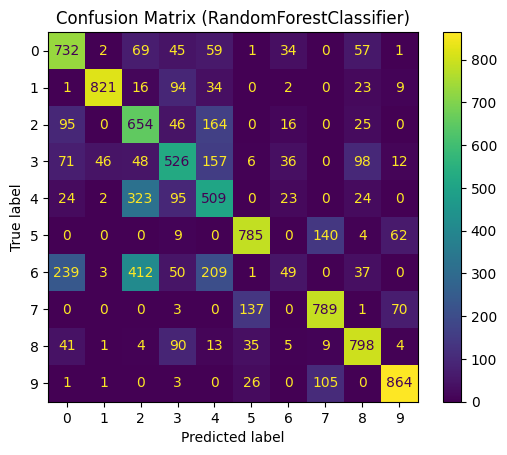

              precision    recall  f1-score   support

           0       0.61      0.73      0.66      1000
           1       0.94      0.82      0.88      1000
           2       0.43      0.65      0.52      1000
           3       0.55      0.53      0.54      1000
           4       0.44      0.51      0.47      1000
           5       0.79      0.79      0.79      1000
           6       0.30      0.05      0.08      1000
           7       0.76      0.79      0.77      1000
           8       0.75      0.80      0.77      1000
           9       0.85      0.86      0.85      1000

    accuracy                           0.65     10000
   macro avg       0.64      0.65      0.63     10000
weighted avg       0.64      0.65      0.63     10000



In [ ]:
# dureaza ~3min
rf_model = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [4],
    'max_features': ['sqrt', 'log2']
}
rf_params, rf_metrics, rf_accuracy = run_model(rf_model, rf_param_grid, X_train, y_train, X_test, y_test)
print(rf_metrics)

## Gradient Boosted Trees

Best parameters: {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 100}


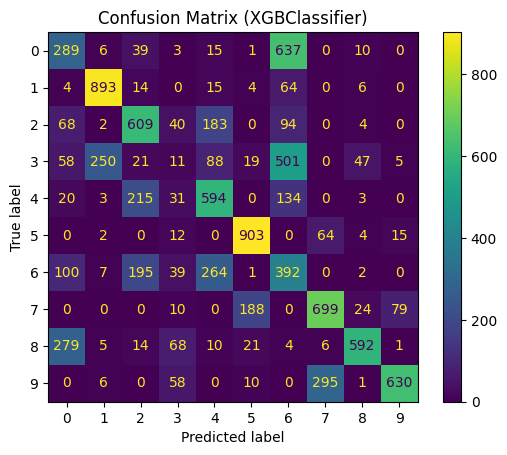

In [ ]:
# dureaza ~
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [4],
    'learning_rate': [0.1, 0.3]
}
xgb_params, xgb_metrics, xgb_accuracy = run_model(xgb_model, xgb_param_grid, X_train, y_train, X_test, y_test)


In [ ]:
print(xgb_metrics)
print(xgb_accuracy)

              precision    recall  f1-score   support

           0       0.35      0.29      0.32      1000
           1       0.76      0.89      0.82      1000
           2       0.55      0.61      0.58      1000
           3       0.04      0.01      0.02      1000
           4       0.51      0.59      0.55      1000
           5       0.79      0.90      0.84      1000
           6       0.21      0.39      0.28      1000
           7       0.66      0.70      0.68      1000
           8       0.85      0.59      0.70      1000
           9       0.86      0.63      0.73      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.55     10000
weighted avg       0.56      0.56      0.55     10000

0.5612
